# **Single-Cell RNA-Seq Analysis Project**

In this project, you will work with the `norman` dataset from the `perturbation_data_analysis` exercise:

In [31]:
import pertdata as pt
import scanpy as sc

norman = pt.PertDataset(name="norman", cache_dir_path="data", silent=False)
norman_raw = norman
print(norman)

print(norman.adata)
# print(f"head {norman.adata.obs.head}")
X = norman.adata.X
y_pert = norman.adata.obs["condition"]
y_ctrl = norman.adata.obs["control"]
gene_names = norman.adata.var["gene_name"]

print(f"X.shape={X.shape}")  # type: ignore
print(f"y_pert.shape={y_pert.shape}")
print(f"y_ctrl.shape={y_ctrl.shape}")
print(f"gene_names.shape={gene_names.shape}")


Loading: /Users/leo/Documents/Workspace/amlg_env/luh_module_amlg_assignment/data/norman/norman/perturb_processed.h5ad
Dataset already cached: /Users/witasweber/environments/anaconda/iML/luh_module_amlg_assignment/data/norman
Loading: /Users/witasweber/environments/anaconda/iML/luh_module_amlg_assignment/data/norman/norman/perturb_processed.h5ad
PertDataset object
    name: norman
    cache_dir_path: /Users/witasweber/environments/anaconda/iML/luh_module_amlg_assignment/data
    path: /Users/witasweber/environments/anaconda/iML/luh_module_amlg_assignment/data/norman
    adata: AnnData object with n_obs ✕ n_vars = 91205 ✕ 5045
AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'
X.shape=(91205, 5045)
y_pert.shape=(91205,)
y_ctrl.shape=(91205,)
gene

In [32]:
print(norman.adata.obs.columns.tolist())
print(norman.adata.var)

print("X-data: ", X[0])


['condition', 'cell_type', 'dose_val', 'control', 'condition_name']
                    gene_name
gene_id                      
ENSG00000239945  RP11-34P13.8
ENSG00000223764   RP11-54O7.3
ENSG00000187634        SAMD11
ENSG00000187642         PERM1
ENSG00000188290          HES4
...                       ...
ENSG00000198786        MT-ND5
ENSG00000198695        MT-ND6
ENSG00000198727        MT-CYB
ENSG00000273554    AC136616.1
ENSG00000278633    AC023491.2

[5045 rows x 1 columns]
X-data:  <Compressed Sparse Row sparse matrix of dtype 'float32'
	with 426 stored elements and shape (1, 5045)>
  Coords	Values
  (0, 5)	0.6815017461776733
  (0, 37)	1.5907396078109741
  (0, 50)	1.083054780960083
  (0, 57)	0.6815017461776733
  (0, 72)	1.083054780960083
  (0, 77)	0.6815017461776733
  (0, 87)	0.6815017461776733
  (0, 88)	1.083054780960083
  (0, 91)	1.3687750101089478
  (0, 94)	1.083054780960083
  (0, 97)	2.058972120285034
  (0, 98)	0.6815017461776733
  (0, 111)	1.3687750101089478
  (0, 120)	1.3687

In [33]:
import pandas as pd

def generate_fixed_perturbation_labels(labels: pd.Series) -> pd.Series:

# Remove "ctrl+" and "+ctrl" matches.
    labels_fixed = labels.str.replace(pat="ctrl+", repl="")
    labels_fixed = labels_fixed.str.replace(pat="+ctrl", repl="")

    return labels_fixed

In [34]:
print(f"Unique perturbations (unfixed): {len(set(norman.adata.obs['condition']))}")

norman.adata.obs["condition_fixed"] = generate_fixed_perturbation_labels(
    labels=norman.adata.obs["condition"]
)

print(f"Unique perturbations (fixed): {len(set(norman.adata.obs['condition_fixed']))}")

Unique perturbations (unfixed): 284
Unique perturbations (fixed): 237


## Filter out double-gene pertubations
Focusing on just single gene pertubatinos to make the analysis easier

In [35]:
filter_mask = ~norman.adata.obs["condition_fixed"].str.contains(r"\+")
indexes_to_keep = filter_mask[filter_mask].index
adata_single = norman.adata[indexes_to_keep].copy()  # type: ignore

In [36]:
print(adata_single)

AnnData object with n_obs × n_vars = 55760 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'


# QC


In [37]:
# Get the AnnData object from PertDataset
adata = adata_single.copy()
# adata = norman.adata

#  mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

# QC metrics -> braucht man für qc-plots
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=True)

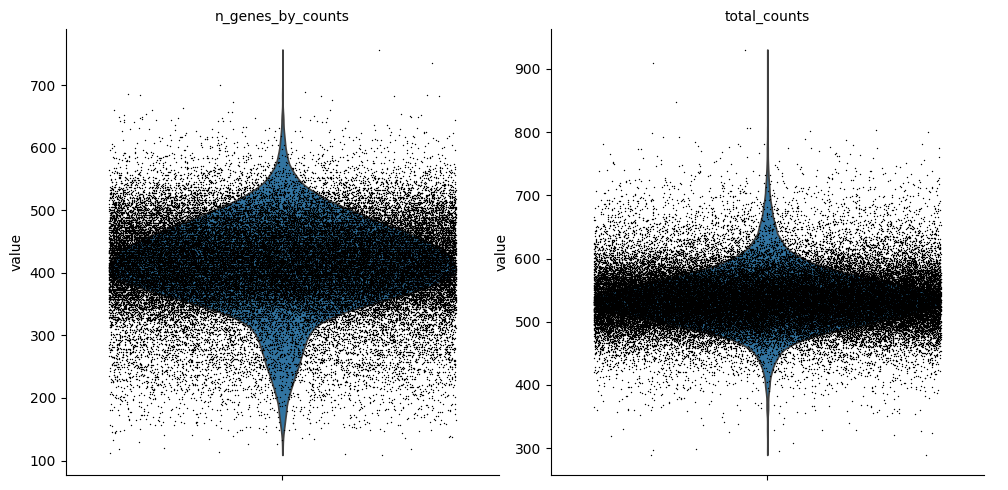

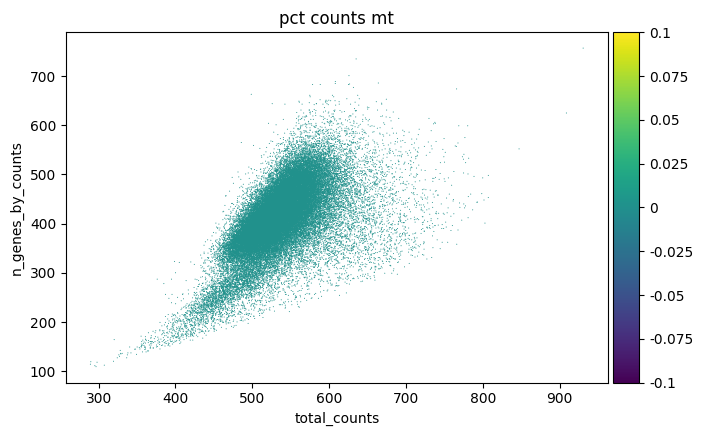

In [38]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts'], 
             jitter=0.4, multi_panel=True)
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

## Filter

In [39]:
adata_filtered = adata.copy()
# sc.pp.filter_cells(adata, min_genes=100)
# sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata_filtered, min_genes=200)
sc.pp.filter_genes(adata_filtered, min_cells=3)

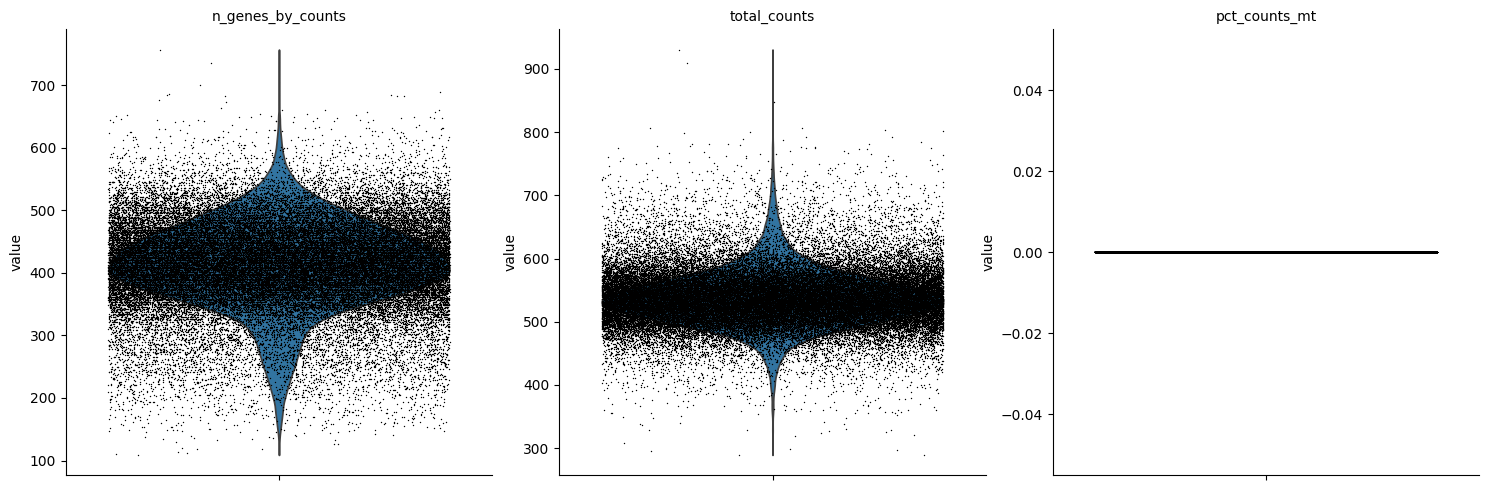

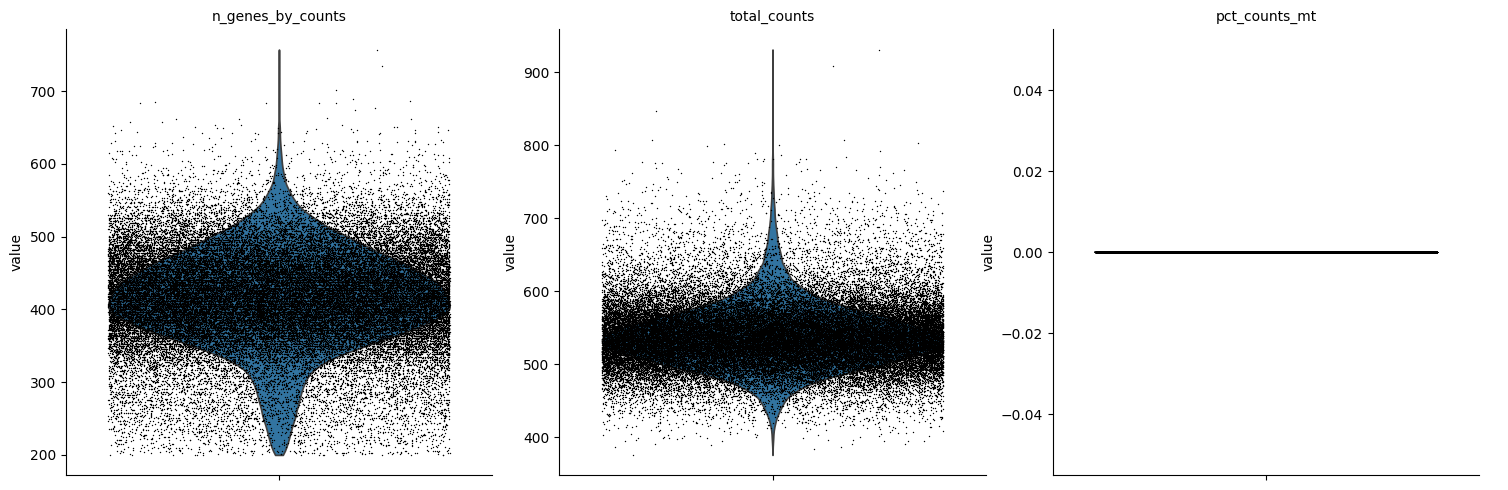

In [40]:

sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
             jitter=0.4, multi_panel=True)
             
sc.pl.violin(adata_filtered, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], 
             jitter=0.4, multi_panel=True)


## Normalizing

In [41]:
# Library size normalisieren
sc.pp.normalize_total(adata_filtered, target_sum=1e4)
# Log-transformieren
sc.pp.log1p(adata_filtered)

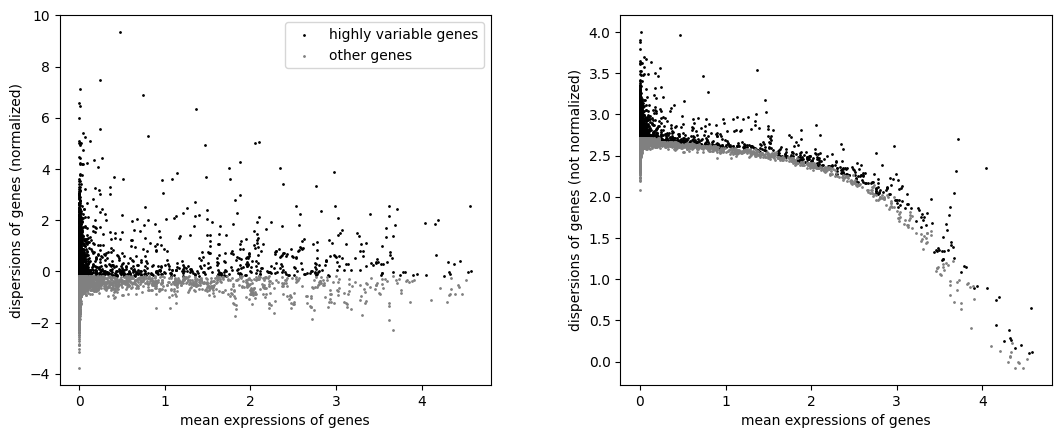

In [42]:
sc.pp.highly_variable_genes(adata_filtered, n_top_genes=2000)
sc.pl.highly_variable_genes(adata_filtered)

#### Getting highly variable genes for the data

In [43]:
#highly_variable_mask = adata_filtered.var["highly_variable"].values
#adata_hiVariGenes = adata_filtered[:, highly_variable_mask].copy() 

#sc.pp.highly_variable_genes(adata_filtered, n_top_genes=2000) #getting the 2000 genes with most variablility
adata_hiVariGenes = adata_filtered[:, adata_filtered.var.highly_variable]

print(f"Shape of highly variable df: {adata_hiVariGenes.shape}")
print(f"Shape of highly only filtered df: {adata_filtered.shape}")


Shape of highly variable df: (55380, 2000)
Shape of highly only filtered df: (55380, 4236)


getting the top 2000 genen with the highest variablility

### Scaling Data

In [44]:
sc.pp.scale(adata_hiVariGenes, max_value=10)

/Users/witasweber/environments/anaconda/anaconda3/envs/amlgds_env/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:309: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
/Users/witasweber/environments/anaconda/anaconda3/envs/amlgds_env/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


### PCA plot before regressing out unwanted factors

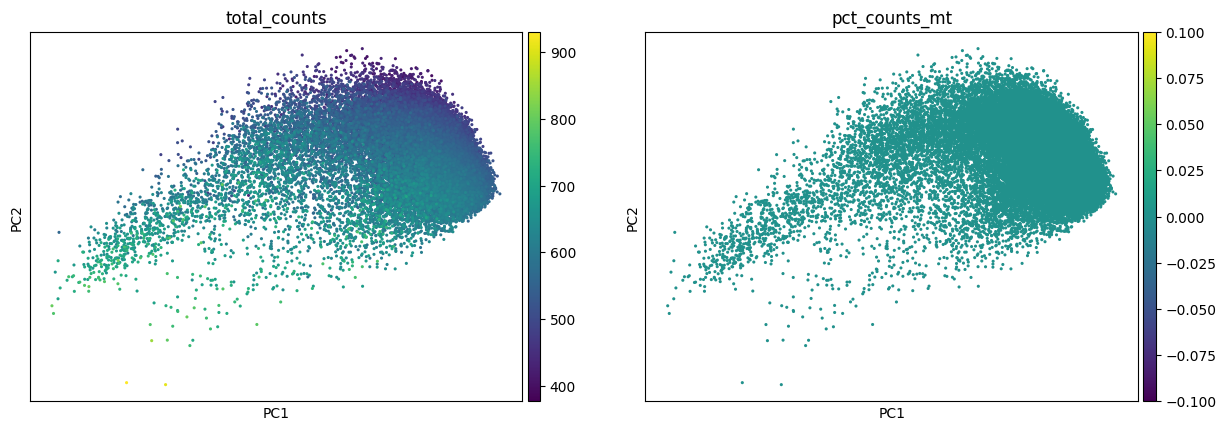

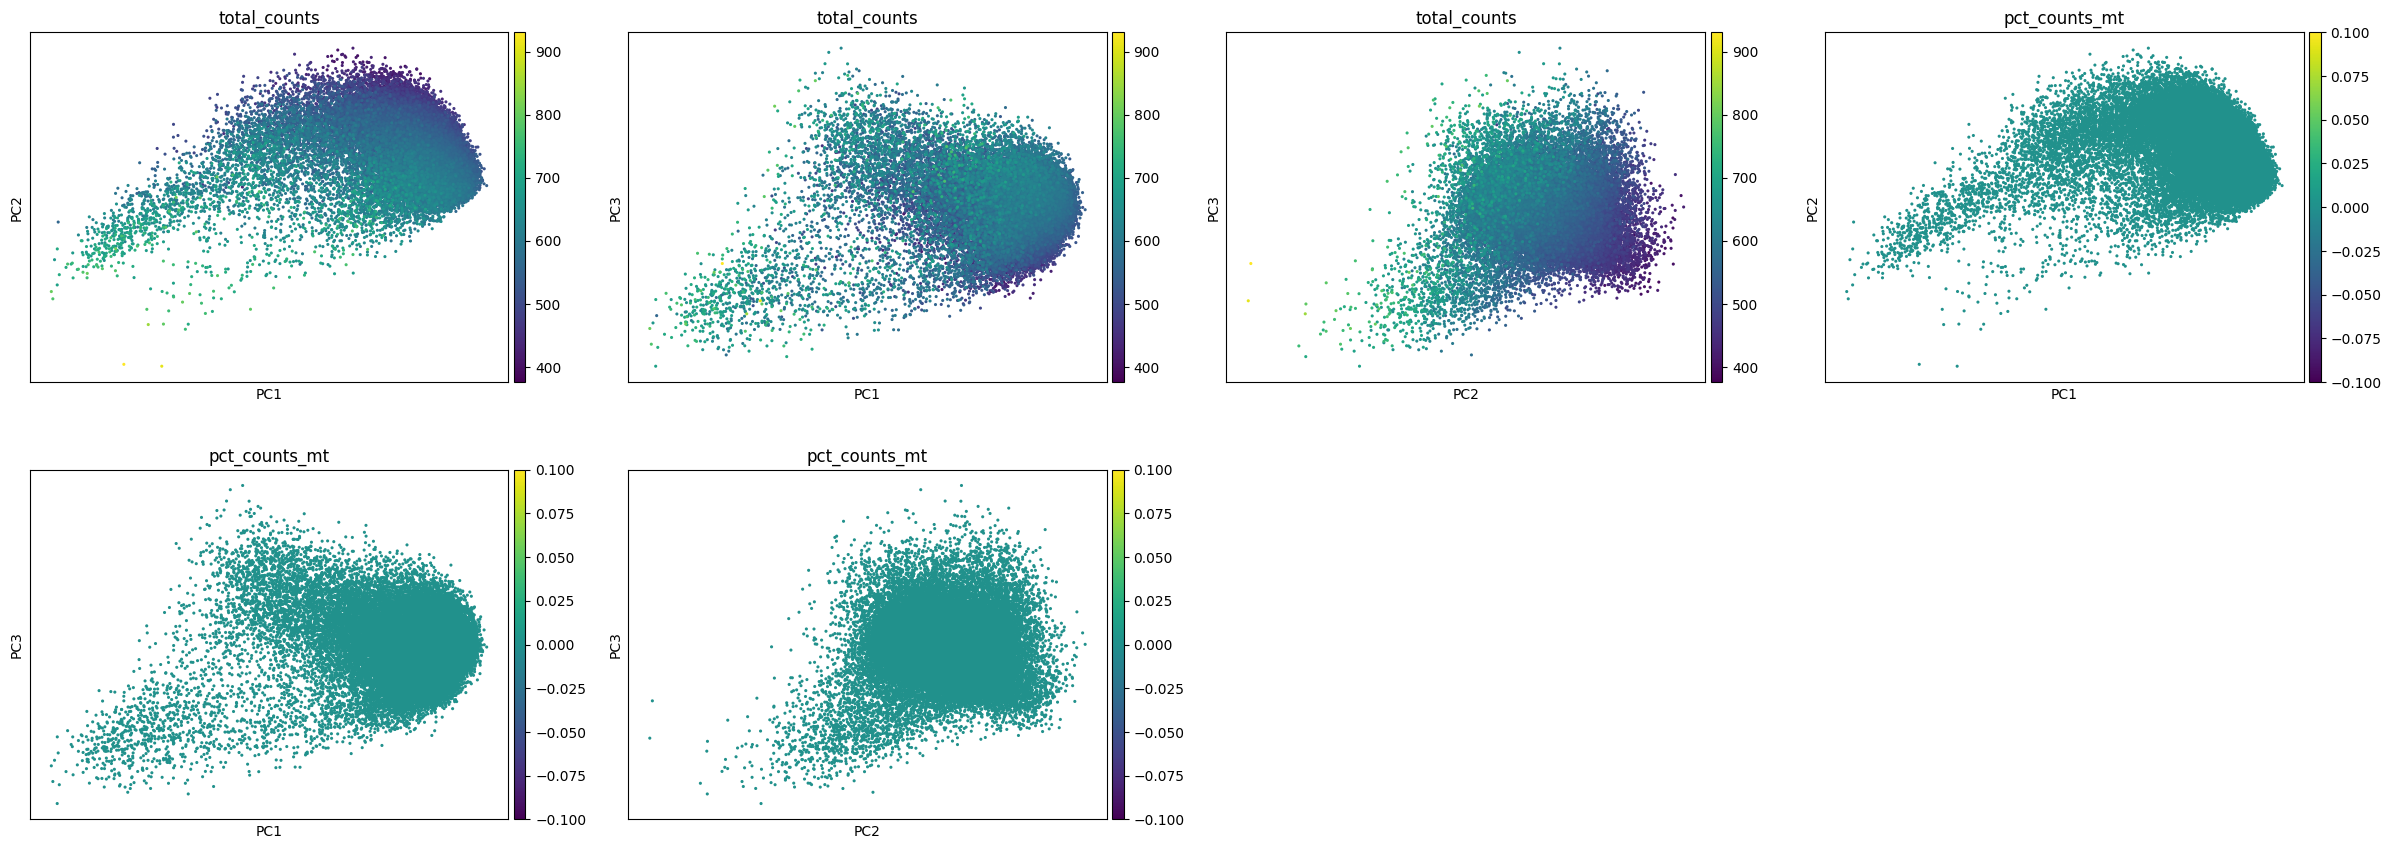

In [45]:
sc.tl.pca(adata_hiVariGenes, n_comps=2)
sc.pl.pca(
    adata_hiVariGenes,
    color=['total_counts', 'pct_counts_mt'],
    components=['1,2'],
    size=20
)

sc.tl.pca(adata_hiVariGenes, n_comps=3)
sc.pl.pca(
    adata_hiVariGenes,
    color=['total_counts', 'pct_counts_mt'],
    components=['1,2', '1,3', '2,3'],
    size=20
)


- once unsing only 2 pcs and once using 3 plotted against ech other 
-> can be seen that the first 2 pcs don´t change that much, when changing adding a third component

### Regressing out unwanted factors

In [46]:
print(adata_hiVariGenes.obs.columns)


sc.pp.regress_out(adata_hiVariGenes, ['total_counts', 'pct_counts_mt'])

Index(['condition', 'cell_type', 'dose_val', 'control', 'condition_name',
       'condition_fixed', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_mt',
       'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo',
       'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb',
       'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'],
      dtype='object')


- total_count and pct_count_mt are highly influencing the outcome of the pc, however they are more technical factors then biological 
- total_count:  is showing how much of this RNA (how many transcripts) is produced -> tends to be a highly influential factor for PCA and clustering but is more of a technical factor -> highly dependent on the sequencing depth and dize of the cell not the pertubation 
- pct_count_mt: gives the number of mitrochondrial reads -> shows stress of the cell and if the cell was damaged or healthy -> can overshadow the pertubation effects in the pca if it´s not regresssed out

### PCA after regressing out unwanted factors

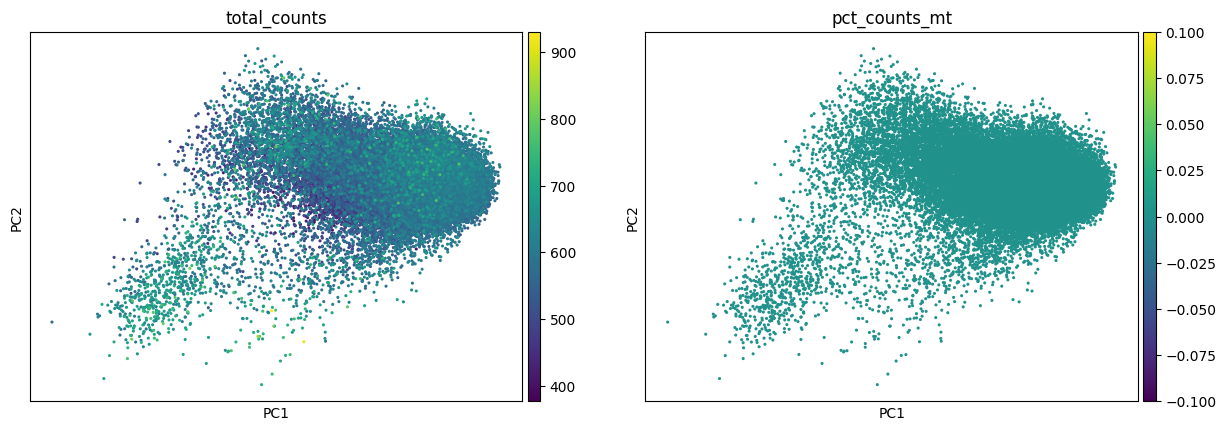

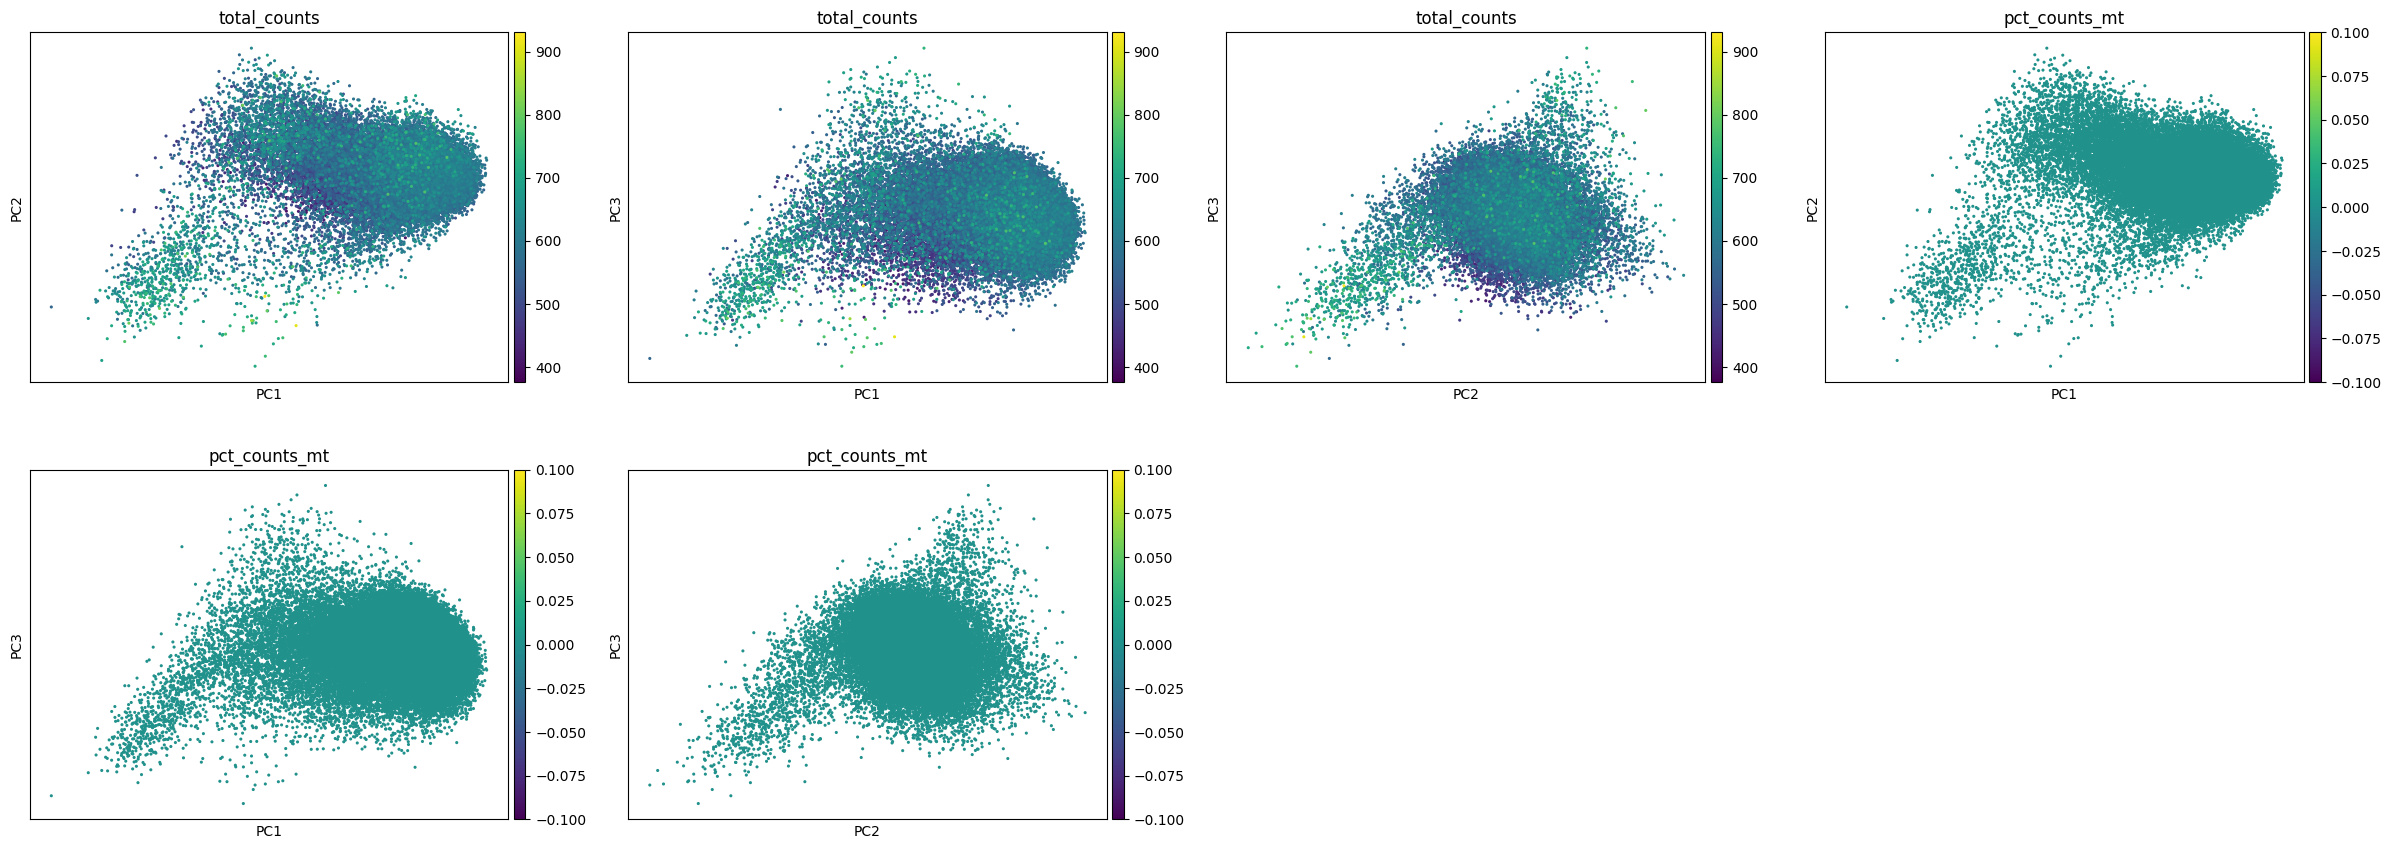

In [47]:
sc.tl.pca(adata_hiVariGenes, n_comps=2)
sc.pl.pca(
    adata_hiVariGenes,
    color=['total_counts', 'pct_counts_mt'],
    components=['1,2'],
    size=20
)

sc.tl.pca(adata_hiVariGenes, n_comps=3)
sc.pl.pca(
    adata_hiVariGenes,
    color=['total_counts', 'pct_counts_mt'],
    components=['1,2', '1,3', '2,3'],
    size=20
)


- can see that the PCA changed drastically after regressing out the disturbing factors
- first slight clusters are showing, especially when plotting pc1 against pc2

### Calculating PCA for 50 Components 

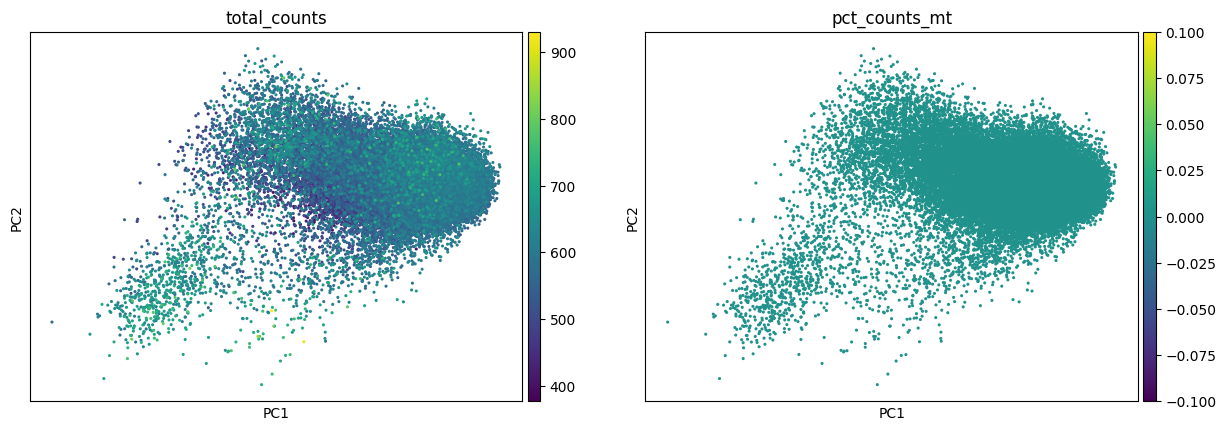

In [48]:
#to use them in t-SNE afterwards 

sc.tl.pca(adata_hiVariGenes, n_comps=50)
sc.pl.pca(
    adata_hiVariGenes,
    color=['total_counts', 'pct_counts_mt'],
    components=['1,2'],
    size=20
)

 - can be seen that when calculating the first 50 PCs, that the first two of them are similar to the PC1 and PC2 when only calculating two PCs 

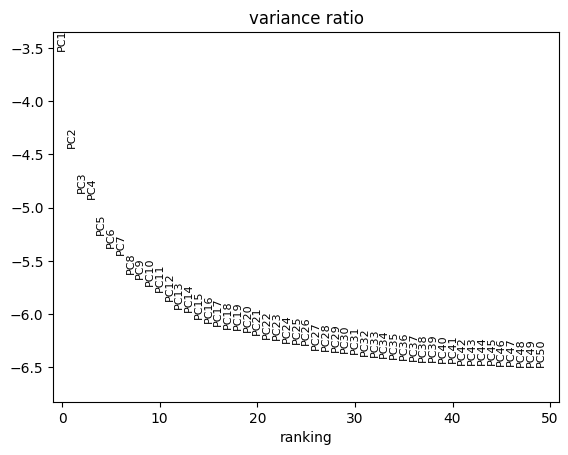

In [49]:
sc.pl.pca_variance_ratio(adata_hiVariGenes, log=True, n_pcs=50)

- this plot shows which of the PCs contains how much new information
- can be seen that the first two cantain by far the most information, hwoever also 3 and 4 are high in information variance
- for calculating t-SNE afterwards it is usefull to use all 50 comonents because they contain information about the more rare genes

### Implementation of Leiden Clustering and visualization using UMAP

In [50]:
sc.pp.neighbors(adata_hiVariGenes, n_pcs=50, n_neighbors=15) 

sc.tl.leiden(adata_hiVariGenes, resolution=0.3)

- calculating the matrix of the local neighborhoods of the points/genes 
- 50 pcs like in the pca -> keeping most of the vairance/information
- 15 neighorhood size through testigna nd adjusting the parameters 

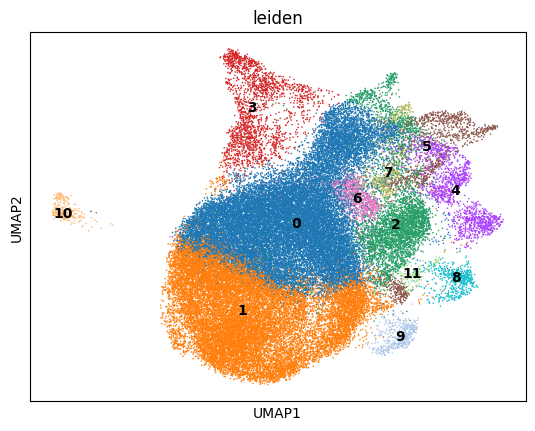

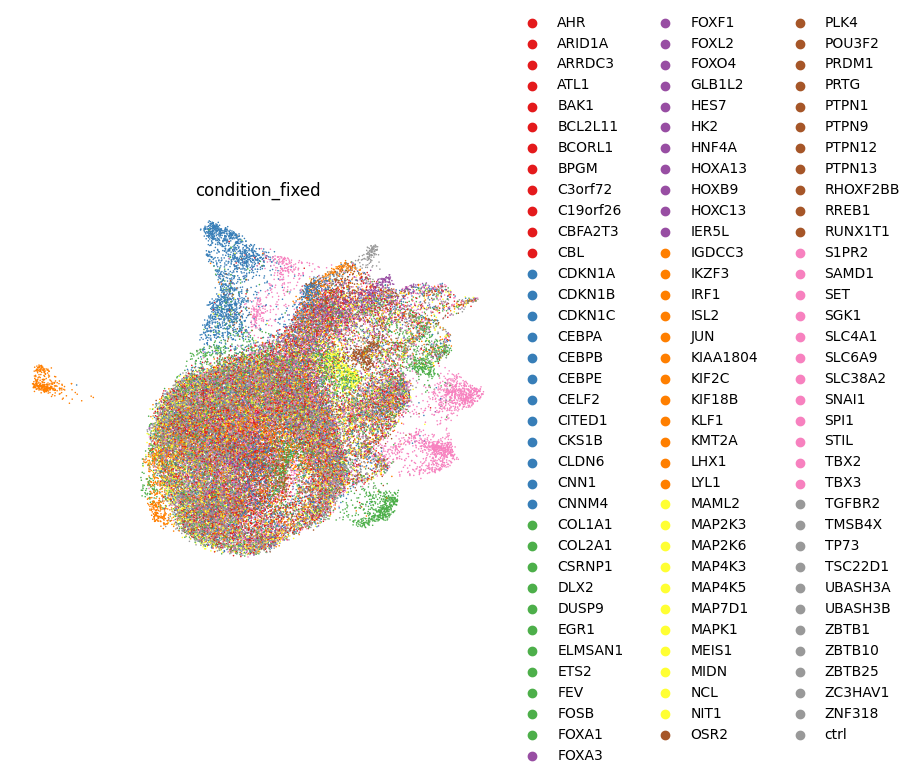

leiden
0     24412
1     19270
2      4117
3      2063
4      1462
5      1216
6       834
7       563
8       552
9       462
10      293
11      136
Name: count, dtype: int64
Anzahl Cluster: 12


In [51]:
sc.tl.umap(adata_hiVariGenes)

sc.pl.umap(adata_hiVariGenes, color='leiden', legend_loc='on data', size=5)
sc.pl.umap(adata_hiVariGenes, color='condition_fixed', size=5,  palette='Set1', frameon=False)

# Statistik
print(adata_hiVariGenes.obs['leiden'].value_counts())
print(f"Anzahl Cluster: {len(adata_hiVariGenes.obs['leiden'].unique())}")

- can be seen that some of the leiden clusters are well corresponding to the some of the pertubations -> can be interpreted that some of the pertubations group up and show a similar kind of gene expression which can be shown using clustering

### Ranking the top genes and creating a heatmap to emphasize them

In [52]:
sc.tl.rank_genes_groups(
    adata_hiVariGenes,
    groupby='leiden',
    method='wilcoxon'
)


/Users/witasweber/environments/anaconda/anaconda3/envs/amlgds_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/witasweber/environments/anaconda/anaconda3/envs/amlgds_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/witasweber/environments/anaconda/anaconda3/envs/amlgds_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/witasweber/environments/anaconda/anaconda3/envs/amlgds_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/Users/witasweber/environments/anaconda/anac

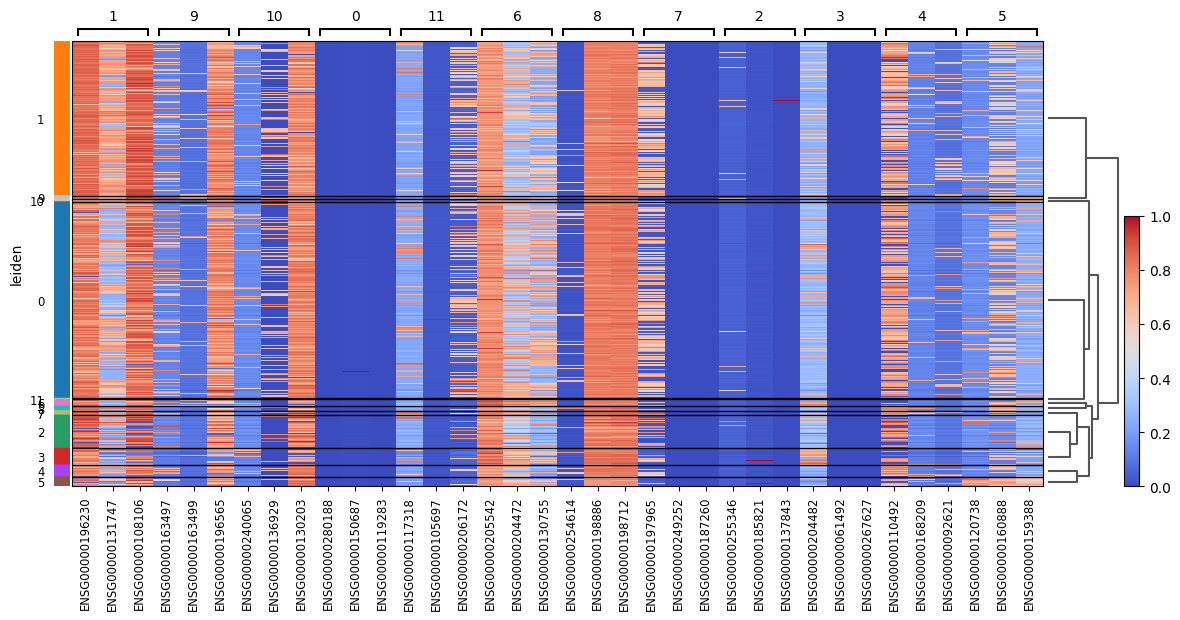

In [65]:
sc.pl.rank_genes_groups_heatmap(adata_hiVariGenes,
                                n_genes=3,
                                groupby='leiden',
                                figsize=(14, 6),
                                show_gene_labels=True,
                                cmap= 'coolwarm',
                                standard_scale='var')

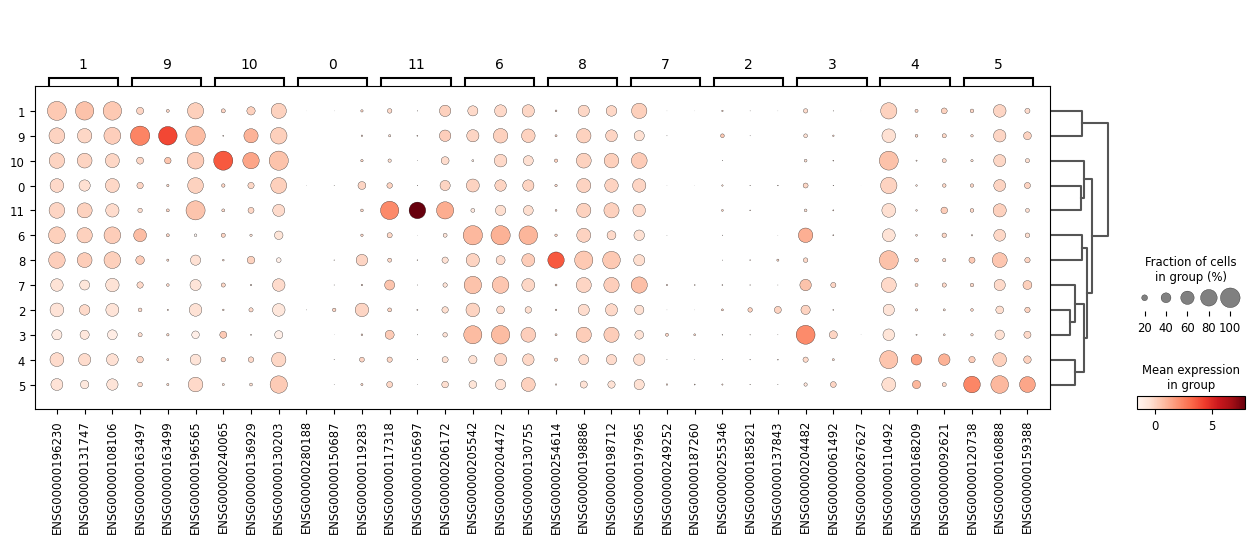

In [64]:
sc.pl.rank_genes_groups_dotplot(adata_hiVariGenes, n_genes=3, groupby='leiden')

### Gene expression profiles

In [58]:
import numpy as np


expression_profiles = {}

for condition in adata_hiVariGenes.obs['condition_fixed'].unique():
    if pd.isna(condition):
        continue
    
    # Zellen für diese Perturbation filtern
    mask = adata_hiVariGenes.obs['condition_fixed'] == condition
    cells_of_condition = adata_hiVariGenes[mask]
    
    # Mittlere Expression für jedes Gen
    mean_expr = cells_of_condition.X.mean(axis=0)
    
    # Als Array speichern und in DataFrame umwandeln
    expression_profiles[condition] = np.asarray(mean_expr).flatten()

# DataFrame mit Genen als Zeilen und Perturbationen als Spalten
gep_df = pd.DataFrame(
    expression_profiles,
    index=adata_hiVariGenes.var_names
)

print(gep_df.shape)  # z.B. (2000, 156) -> 2000 Gene, 156 Perturbationen
print(gep_df.head())


(2000, 106)
                  TSC22D1      ctrl     MAML2     CEBPE     DUSP9   ELMSAN1  \
gene_id                                                                       
ENSG00000239945 -0.001262 -0.001218 -0.001209 -0.001548 -0.001337  0.011702   
ENSG00000187634 -0.081732 -0.029030  0.011880  0.109940 -0.045743 -0.039568   
ENSG00000187642 -0.001262 -0.001223 -0.001215 -0.001517 -0.001329 -0.001207   
ENSG00000237330 -0.022391 -0.019841 -0.020984 -0.030100  0.021590 -0.007771   
ENSG00000186891 -0.004469 -0.002489 -0.003740  0.010877 -0.005525 -0.003602   

                    FOXA1    BCORL1     MEIS1    GLB1L2  ...   SLC38A2  \
gene_id                                                  ...             
ENSG00000239945 -0.001244 -0.001218  0.013480 -0.001265  ... -0.001209   
ENSG00000187634  0.030634 -0.077322  0.008942 -0.047788  ...  0.003939   
ENSG00000187642 -0.001247 -0.001223 -0.001283 -0.001265  ... -0.001216   
ENSG00000237330 -0.008659 -0.021226 -0.008221 -0.022473  ... -0.

In [59]:
# Nicht nur Mean, sondern auch Std Dev, Median, Varianz
extended_profiles = pd.DataFrame()

for condition in adata_hiVariGenes.obs['condition_fixed'].unique():
    if pd.isna(condition):
        continue
    
    mask = adata_hiVariGenes.obs['condition_fixed'] == condition
    cells_of_condition = adata_hiVariGenes[mask]
    X = cells_of_condition.X
    
    mean_expr = np.asarray(X.mean(axis=0)).flatten()
    std_expr = np.asarray(X.std(axis=0)).flatten()
    median_expr = np.asarray(np.median(X, axis=0)).flatten()
    
    extended_profiles[f"{condition}_mean"] = mean_expr
    extended_profiles[f"{condition}_std"] = std_expr
    extended_profiles[f"{condition}_median"] = median_expr

extended_profiles.index = adata_hiVariGenes.var_names
print(extended_profiles.shape)  # z.B. (2000, 468) -> 3x statistisch pro Perturbation


/var/folders/g1/thrm7ddx7tg0xczpz_4zz6080000gn/T/ipykernel_45345/3028120812.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  extended_profiles[f"{condition}_std"] = std_expr
/var/folders/g1/thrm7ddx7tg0xczpz_4zz6080000gn/T/ipykernel_45345/3028120812.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  extended_profiles[f"{condition}_median"] = median_expr
/var/folders/g1/thrm7ddx7tg0xczpz_4zz6080000gn/T/ipykernel_45345/3028120812.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

(2000, 318)


/var/folders/g1/thrm7ddx7tg0xczpz_4zz6080000gn/T/ipykernel_45345/3028120812.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  extended_profiles[f"{condition}_mean"] = mean_expr
/var/folders/g1/thrm7ddx7tg0xczpz_4zz6080000gn/T/ipykernel_45345/3028120812.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  extended_profiles[f"{condition}_std"] = std_expr
/var/folders/g1/thrm7ddx7tg0xczpz_4zz6080000gn/T/ipykernel_45345/3028120812.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `f

In [60]:
# Mean expression pro Leiden cluster
leiden_profiles = {}

for cluster in adata_hiVariGenes.obs['leiden'].unique():
    mask = adata_hiVariGenes.obs['leiden'] == cluster
    cells_in_cluster = adata_hiVariGenes[mask]
    
    mean_expr = cells_in_cluster.X.mean(axis=0)
    leiden_profiles[f"cluster_{cluster}"] = np.asarray(mean_expr).flatten()

leiden_gep_df = pd.DataFrame(
    leiden_profiles,
    index=adata_hiVariGenes.var_names
)

print(leiden_gep_df.shape)  # z.B. (2000, 8) -> 2000 Gene, 8 Cluster


(2000, 12)


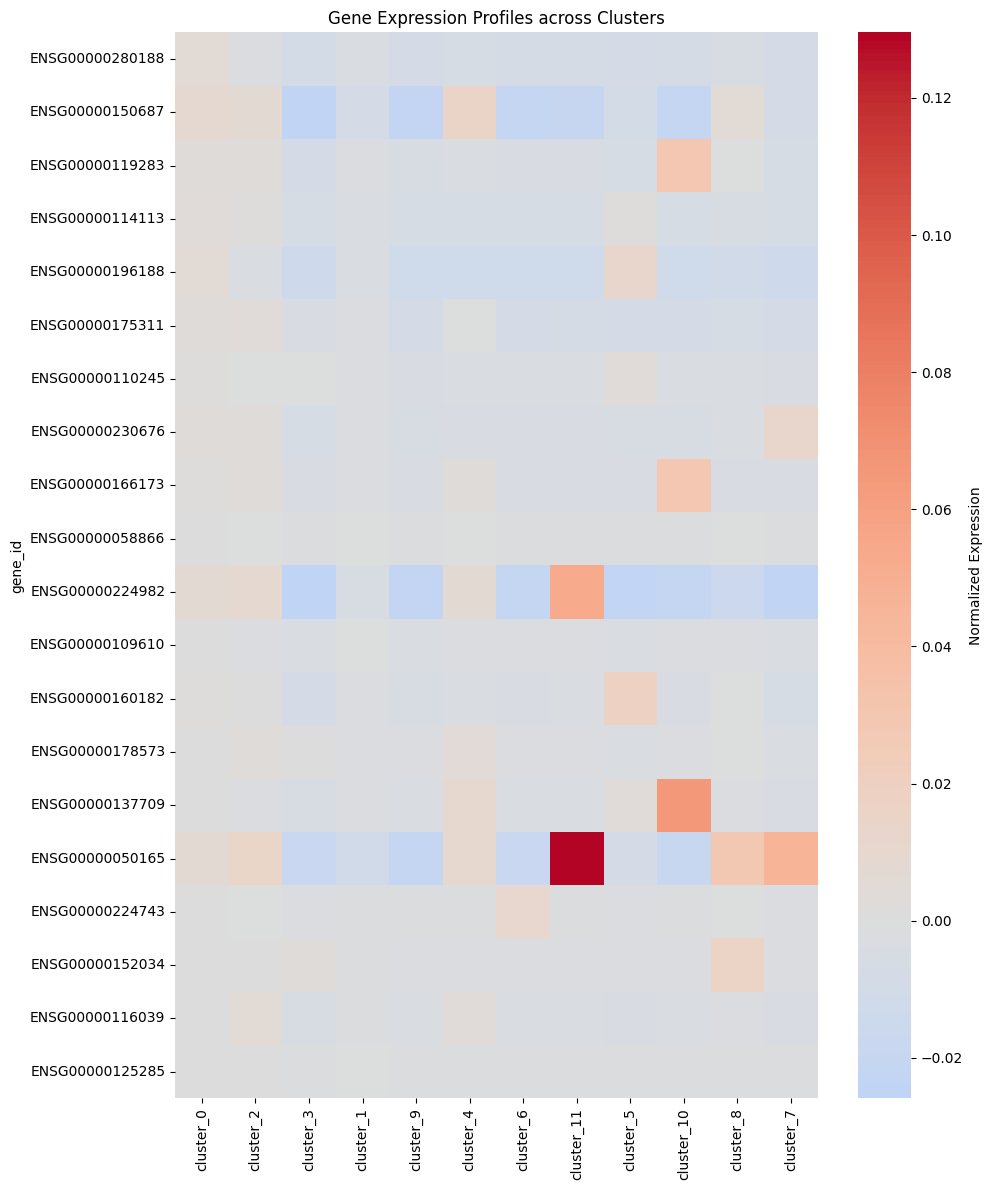

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top differenzial exprimierte Gene hervorheben
# Nutze die Results aus sc.tl.rank_genes_groups()

# Option A: Top Gene pro Cluster
top_genes = sc.get.rank_genes_groups_df(adata_hiVariGenes, group='0').head(20)['names'].tolist()

# Subset der Gene Expression Profiles
subset_profiles = leiden_gep_df.loc[top_genes]

# Heatmap erstellen
plt.figure(figsize=(10, 12))
sns.heatmap(subset_profiles, 
            cmap='coolwarm',
            center=0,
            cbar_kws={'label': 'Normalized Expression'})
plt.title('Gene Expression Profiles across Clusters')
plt.tight_layout()
plt.show()


Choose one of the following tasks:

**Exploratory Data Analysis and Visualization**

- Objective: Explore the dataset to identify patterns and clusters.
- Tasks:
  - Perform dimensionality reduction using PCA, t-SNE, or UMAP.
  - Visualize gene expression profiles across different conditions or perturbations.
  - Create heatmaps of the top differentially expressed genes.
- Learning Outcomes:
  - Learn to visualize high-dimensional data.
  - Interpret clusters and patterns in the context of biological conditions.

**Machine Learning Classification**

- Objective: Build models to classify samples based on gene expression profiles.
- Tasks:
  - Split the dataset into training and testing sets.
  - Implement classification algorithms.
  - Evaluate model performance using metrics like accuracy, precision, recall, and ROC curves.
- Learning Outcomes:
  - Understand supervised learning techniques.
  - Learn model evaluation and validation strategies.

**Advanced Deep Learning Applications**

- Objective: Apply deep learning techniques to model complex patterns in the data.
- Tasks:
  - Implement autoencoders or variational autoencoders for dimensionality reduction.
  - Explore the use of GANs to generate synthetic gene expression data.
  - Analyze how deep learning models capture nonlinear relationships.
- Learning Outcomes:
  - Gain experience with deep learning frameworks.
  - Understand the applications of deep learning in genomics.